<a id='introduction'></a>
# 1. Introduction #
Welcome to our notebook "Gemma 2 for American English Crosswords". 

Our goal in this notebook is two-fold.

Firstly, we want to demonstrate the complete end to end process of fine-tuning Gemma 2 for our use-case, which is generating crossword clues, but in a straight forward enough way that it can be adapted to any other use-case out there. We do this by demonstrating:
* The building of a large synethetic dataset of American English words for training.
* Fine-tuning, including selecting hyperparameters and monitoring convergence during training
* Inference, including assessing the robustness of our model, as well as viewing the impact of inference parameters like temperature. 

Secondly, we also want to explore our chosen language English (American) and the suprinsingly deep cultural context of crosswords. We do this by:
* Providing some background on crossword puzzles and their cultural impact
* Exploring words unique to the American English language

Ultimately we bring these two ideas, model fine-tuning and crosswords together, and let the reader directly interact with a crossword whose clues are built purely by Gemma 2, made available at [a web application](https://finetunecrossword.online/) which I hope encourages people to not only fine-tune Gemma, but think about how to then use it in new and creative ways in the real world!


### Table of contents ###
1. [Introduction](#introduction)
2. [Crosswords in US Culture](#crossword_introduction)
3. [Building the Perfect Dataset](#datset_introduction)
    1. [Ethical/Legal Constraints](#ethical_constraints)
    2. [Building a Synthetic Clue Dataset](#synethic_dataset)
4. [Finetuning Gemma](#finetuning)
    1. [Model Selection](#model_selection)
    2. [Formatting the Dataset](#dataset_formatting)
    3. [Training Parameters](#training_parameters)
    4. [Monitoring Performance with Weights & Biases](#monitoring_performance)
    5. [Saving the Trained Model](#save_model)
5. [Inference and Use Cases](#inference)
    1. [Loading the Model](#load_model)
    2. [Testing the Model](#testing_the_model)
    3. [Generating English (American) Clues with Gemma](#generating_american_clues)
    4. [Can you take on Gemma's clues?](#interact_with_gemma)
6. [Conclusion](#conclusion)
7. [Appendix](#appendix)

In [ ]:
!pip install bitsandbytes==0.43.1
!pip install accelerate
!pip install trl==0.12.2
!pip install peft
!pip install wandb

In [ ]:
## Data processing and ML
import torch
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

## Transformers ecosystem
import transformers
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer, 
    BitsAndBytesConfig,
    TrainerCallback
)
from transformers.integrations import WandbCallback
from trl import SFTTrainer
from peft import LoraConfig
from datasets import Dataset

## Authentication and logging
import wandb
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

<a id='crossword_introduction'></a>
# 2. Crosswords in US Culture #
Before we dive into fine-tuning a model, it's important to outline why crosswords are actually quite an interesting use-case from a cultural point of view. 

Crosswords are simple on the surface, you get a clue and have to guess what word that corresponds to. Diving a bit deeper though and we see crosswords currently form a key distinct use of the English (American) language and have for quite a long time - In fact, the first crossword puzzle was published in 1910! In our current time, major American publications such as the New York Times, The New Yorker, Wall Street Journal and L.A Times all maintain their own crossword sections. The most famous of these, the New York Times, began publishing its crossword in 1942 and has now become a daily ritual for a large number of readers (okay, you got me, I'm included in those users 🤓). 

As well as their longevity, crosswords also typically reflect the culture of the current time. For example, in the first ever NYT crossword in 1942, a clue was "G-man Hoover's middle name." The answer to this clue was of course "EDGAR" referring to J. Edgar Hoover, a key figure in the FBI at the time. In modern crosswords now it isn't unusual to see current slang, for example, recently the clue "$100, in slang" with the answer "Hundo" was used by the New York Times.  

One last important note is that American style crosswords (as opposed to British ones) is that they typically feature clues that involve wordplay as well. 

The above two factors, that crosswords will both reflect current culture and contain creative wordplay, forms a unique challenge for LLMs. LLMs are typically trained on human feedback that rewards them for being clear and direct with their answers, but here we'll be encouraging Gemma to do the opposite - A clear crossword clue sucks, we want Gemma to learn how to give us an abstract clue, but not so abstract that it won't lead us to the right word! Let's see what we can get Gemma to do!

<a id='dataset_introduction'></a>
# 3. Building the Perfect Dataset #
Of course before we can train Gemma 2 for our use-case, we must make sure we've got a dataset of both crossword clues, and also the correct answer. 

<a id='ethical_constraints'></a>
## 3.A Ethical/Legal Constraints ##
Kaggle actually has a perfect dataset that we could use for crossword generation, namely a dataset of [New York Times crossword clues from 1993 to 2021](https://www.kaggle.com/datasets/darinhawley/new-york-times-crossword-clues-answers-19932021). However, directly training a model on these clues and answers would be a grey area both in terms of legality and ethics. That's because these clue and answer pairs, especially in their entirety are likely to be the intellectual property of the NYT. That being the case, we decide to avoid using a dataset of past crosswords from commercial publications. This might sound like a big loss, but actually it's much more fun to build our own anyway! 

## 3.B Building a Synthetic Clue Dataset ##
Okay, so we need clues to train our dataset, but we're no crossword experts ourselves, and even if we were, it would be incredibly time consuming to generate enough word and clue pairs for a full dataset. So what do we do? We opt for synthetic data generated by frontier models! At the time of building this notebook the top models are OpenAI's GPT-4o, Claude Sonnet 3.5, and of course Google's own Gemini 1.5.

### Clue Generation Process ###
To build up a synthetic set of crossword clues and answers, we follow this process:

1. **Identify Common Words in the American English language**: We take the [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus). The Brown Corpus is a small 1 million word corpus, but the first corpus built for the American English language which is perfect for our chosen language, and it's easily accessable from the NLTK package. From here we calculate the most frequently occurring words.
2. **Choose a common word**: We then select a commonly occurring word, and will ask our models to generate clues for that word.
3. **Specify a type of clue**: We want diversity in our clues, so we ask the set of models to produce a specific type of crossword clue for each word.
4. **LLM Judging**: We set up another LLM to review the three candidates and select a winning clue for fine-tuning.

### Clue Type Distribution ###
We distribute our clue types according to difficulty and style:
* Easy Clues (60% of the time): We generate a straightforward clue, e.g. "has a large trunk" as a clue for elephant
* Moderate Clues (15% of the time): We generate a more difficult clue, e.g. "largest land animal" is a slightly harder clue for elephant. 
* Fill in the Blank Clues (10% of the time): We generate a fill in the blank clue, e.g. "___ in the room" which requires us to realise the saying is "elephant in the room". 
* Wordplay clues (7.5% of the time): We generate a creative wordplay clue, e.g. "unforgettable one?" since elephants are known for their memory
* Example clues (7.5% of the time): We generate an "example clue", e.g. "Jumbo, perhaps", since Jumbo is an example of an elephant

### Selection Criteria ###
Our judge LLM reviews candidates according to:
* Accuracy and appropriateness
* Adherence to clue type format
* Clarity and fairness
* Avoidance of the answer in the clue
* Following crossword conventions

Appreciate that sounds like quite a complex process, so the below diagram breaks it down into steps to make it clear. We use an example which is the word "first", and leads to row 6 which we show in the dataset below the diagram:


<center>
    <img src="https://github.com/rhyscook92/Kaggle-Gemma-Finetune/blob/main/images/data_generation_pipeline.PNG?raw=true" width="600px">
</center>

**Figure 1:** A step by step breakdown of the synthetic data generation process.

Okay, enough talk! Let's start to get into some code.

The below code reads in our dataset and prints the first 7 rows. The last of those is the word "first", which is the example used in the above figure. 
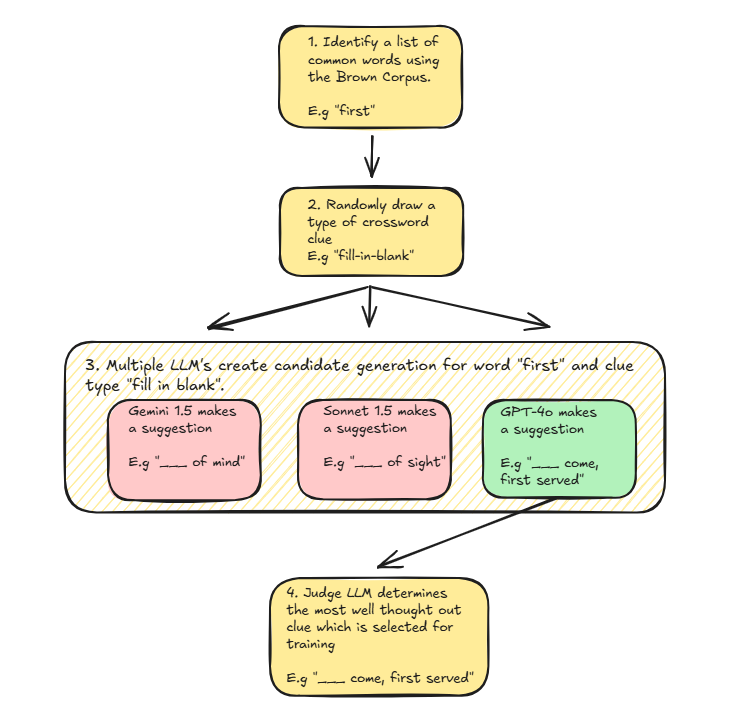

In [ ]:
df = pd.read_csv('/kaggle/input/ai-generated-crossword-clues/ai_generated_crossword_clues.csv')

# Filter out rows where "Winning Clue" is NaN
df = df[~df['Winning Clue'].isna()].reset_index(drop=True)
df.head(7)

**Table 1:** A breakdown of synethically generated crossword clues. We see the target word, the type of clue being asked for, and the candidates suggested by each model during generation. Finally we can see what the LLM judge decided was the best clue, and which model presented it, as well as why. The only two columns we use for training are "Word" the word we need a clue for, and "Winning Clue", which represents an interesting clue developed by frontier models for the target word. 

Note: For those that want to do a deepdive into the dataset generation code, I ran it outside the kaggle notebook because it does run for awhile, but I've made the exact code [publically avaliable on my github](https://github.com/rhyscook92/synthetic_crossword_clues) under an open license, so everyone is free to browse it and adapt it to whatever usecase might suit you best! The repo contains the same explanation as above, as well as fully commented code to break down the individual components. The final dataset is attached to this notebook. 

<a id='finetuning'></a>
# 4. Fine-tuning Gemma #
Now that we have a dataset we need to go through the process of fine-tuning Gemma for crossword clue generation. We break that down into:
* Selecting the right model
* Making sure our dataset is formatted correctly
* Choosing the right hyperparameters
* Monitoring the model during training
  
<a id='model_selection'></a>
## 4.A Model Selection ##
Our model selection process focused on keeping things as practical and streamlined as possible. For that reason we will use the 2b instruction tuned (it) variant of Gemma 2.

2b is selected over 9b as its small size allows for rapid prototyping versus the larger variant (runs generally complete in less than 15 minutes, versus 2 hours). This is beneficial because it means we can quickly test different parameters and reach a working proof of concept. 

Furthermore, we start with the instruction-tuned model as we found that it more rapidly converged to producing the right format needed for crossword clues, perhaps due to already being fine-tuned on responding to prompts in a conversational manner.

We further streamline things by loading the model using 4-bit quantization via the BitsAndBytes library. This reduces the model's memory footprint significantly and allows us to train with bigger batch sizes, speeding things up even more. 

Let's load the model and run a quick test to ensure everything is working as expected:

In [ ]:
# Logins
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("hf_token")
login(hf_token)

# Model Params
model_id = "google/gemma-2-2b-it"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# Load Model
tokenizer = AutoTokenizer.from_pretrained(model_id, token=hf_token)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, token=hf_token)

# Sample generation
text = "Generate a clever crossword clue for the word: 'jail':"
device = "cuda:0"
inputs = tokenizer(text, return_tensors="pt").to(device)

outputs = model.generate(**inputs, max_new_tokens=20)
print(tokenizer.decode(outputs[0], skip_special_tokens=False))

<a id='dataset_formatting'></a>
## 4.B Formatting the Dataset ##
The synthetic dataset gave us "word" and "clue" pairs, but we want the fine-tuning to take place on exactly the same format we intend to use for inference with Gemma 2. Since we're using the instruction-tuned Gemma 2 variant, this inference should take place in a conversational manner. We thus set up a function below to convert each clue word pair in our dataset into a conversational training snippet following [the format in the Gemma documentation which matches the instruction tuning](https://ai.google.dev/gemma/docs/formatting#formatting-instruction).

The below example shows how we format a word "first" and the suggested clue "___ come, first served" into a full conversation snippet for fine-tuning. The blue text is coming straight from our dataset, everything else is the chat template. 
<div style="border-left: 4px solid #3B82F6; padding-left: 1rem; margin-left: 1rem; margin-top: 1rem; margin-bottom: 1rem;">
&lt;start_of_turn&gt;user<br>
Generate a clever crossword clue for the word: '<span style="color: #3B82F6">first</span>'&lt;end_of_turn&gt;<br>
&lt;start_of_turn&gt;model<br>
Clue: <span style="color: #3B82F6">___ come, first served</span>&lt;end_of_turn&gt;&lt;eos&gt;
</div>

We apply this formatting both to the dataset we will use for training, and a few holdout examples that we will use to evaluate the model during training. 

In [ ]:
# Create formatting function for the text field
def formatting_func(example):
    output_texts = []
    user_prompt = f"Generate a clever crossword clue for the word: '{example['Word']}':"
    model_response = f"Clue: {example['Winning Clue']}"

    # Define the chat templates
    USER_CHAT_TEMPLATE = f"<start_of_turn>user\n{user_prompt}<end_of_turn>\n<start_of_turn>model\n"
    MODEL_CHAT_TEMPLATE = f"{model_response}<end_of_turn>"
    EOS_TOKEN = tokenizer.eos_token
    text = (
        USER_CHAT_TEMPLATE + MODEL_CHAT_TEMPLATE + EOS_TOKEN
    )
    return text

# Split the dataset
eval_samples = 5
train_df, eval_df = train_test_split(
    df,
    train_size=df.shape[0]-eval_samples,
    test_size=eval_samples,
    random_state=42
)


# Add formatted text field to both datasets
train_df['text'] = train_df.apply(formatting_func, axis=1)
eval_df['text'] = eval_df.apply(formatting_func, axis=1)

# Convert the DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)

<a id='training_parameters'></a>
## 4.C Training Parameters ##
Below is our fine-tuning setup. Rather than fine-tune the entire model, we use Low-Rank Adaptation (LoRA) to efficiently adapt the model to our task without starting from scratch. 

### Key Parameters ###
We focused on tuning two critical parameters, learning rate and LoRA rank, and followed a simple rule for LoRA alpha:

**Learning Rate (1e-3):**
- Controls the step size during training
- We found 1e-3 provides optimal convergence
- This is pretty large as far as learning rates go versus say 1e-5 or 1e-4, but those lower learning rates didn't result in the model changing behaviour. 

**LoRA Parameters:**
LoRA, explained in detail on [huggingface](https://huggingface.co/docs/peft/main/en/conceptual_guides/lora), allows efficient fine-tuning by representing weight updates through low-rank decomposition. We tuned:

- **Rank (r=32):** 
  - Controls the number of trainable parameters
  - Lower values stay closer to base model behavior
  - We found r=32 provides good balance between letting the model learn new behaviour without going too wild. 
- **Alpha (α=16):** 
  - Scaling factor for LoRA updates
  - Following the original [LoRA paper](https://arxiv.org/abs/2106.09685), we set α to the first rank tried (which was 16), and made no further changes to this parameter. 

In [ ]:
## Parameters we tune
learning_rate = 1e-3
lora_rank = 32
lora_alpha = 16

# Set up Lora Config
lora_config = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_alpha,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

# Create descriptive run name (useful for Weight's and Biases)
run_name = f"{model_id}_lr{learning_rate:.0e}_alpha{lora_alpha}_rank{lora_rank}"

# Trainer initialization
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        warmup_ratio=0.10,
        num_train_epochs=1,
        learning_rate=learning_rate,
        run_name=run_name,
        fp16=True,
        do_train=True,
        output_dir="outputs",
        optim="paged_adamw_8bit",
        lr_scheduler_type="cosine",
        report_to="wandb",
        logging_strategy="steps",
        logging_steps = 10,
        eval_strategy="steps",
        eval_steps = 10,
        eval_on_start = True
    ),
    peft_config=lora_config,
    dataset_text_field='text',
    max_seq_length=32,
    packing=True,
    dataset_kwargs={
        "add_special_tokens": False
    }
)

<a id='monitoring_performance'></a>
## 4.D Monitoring Performance with Weights & Biases ##
One quick aside - A key reason for entering this competition was to learn a little more about "best practice" in fine-tuning models. For that reason we use one of the more common machine learning ops platforms, [Weights & Biases (W&B)](https://wandb.ai/site/), to monitor training performance. This is a suite of tools (with a free tier :) ) for monitoring the training process of models. Below we cover how it helped in this project, but for those more interested solely in Gemma, feel free to skip this section. 

The two aspects that I find most useful of W&B are:
* **Real time run tracking:** We can track the performance of an individual run in real time. This means if our run looks like a disaster early, we can simply cancel it and try a new setup. This saves a lot of time that would otherwise be spent on poor runs. 
*  **Comparing Hyperparameters:** W&B will save different runs with different setups. This means we can easily compare them after the fact to understand which looks like it's delivering the best results. (Translation: the author always forgets what parameters they're tuning, and W&B stops this). 

Below we set up a custom callback [following the W&B documentation](https://docs.wandb.ai/guides/integrations/huggingface/#custom-logging-log-and-view-evaluation-samples-during-training) that lets us use the LLM as it's being trained to generate responses to our evaluation dataset, and crucially add these completions to a table we can review during training in W&B. 

In [ ]:
class LLMSampleCB(WandbCallback):
    def __init__(self, trainer, test_dataset, device, max_new_tokens=256):
        """A CallBack to log samples to a wandb.Table during training"""
        super().__init__()
        self.sample_dataset = test_dataset
        self.model, self.tokenizer = trainer.model, trainer.tokenizer
        self.device = device
        self.max_new_tokens = max_new_tokens
        self.samples = []
        
    def generate(self, prompt):
        """Generate a model completion for a given prompt"""
        inputs = self.tokenizer(prompt, return_tensors="pt").to(self.device)
        with torch.inference_mode():
            output = self.model.generate(
                **inputs,
                max_new_tokens=self.max_new_tokens,
                use_cache=False,
                cache_implementation=None)
            
        return self.tokenizer.decode(output[0][len(inputs['input_ids'][0]):], skip_special_tokens=False)
    
    def samples_table(self, examples, epoch, step):
        """Create a wandb.Table to store the generations"""
        records_table = wandb.Table(columns=["prompt", "generation", "epoch", "step"])
        for example in examples:
            user_prompt = f"Generate a clever crossword clue for the word: '{example['Word']}':"
            prompt = f"<start_of_turn>user\n{user_prompt}<end_of_turn>\n<start_of_turn>model\n"
            generation = self.generate(prompt=prompt)
            self.samples.append({
                "prompt": prompt,
                "generation": generation,
                "epoch": epoch,
                "step": step
            })
            
        for sample in self.samples:
            records_table.add_data(
                sample["prompt"],
                sample["generation"],
                sample["epoch"],
                sample["step"]
            )
            
        return records_table
        
    def on_evaluate(self, args, state, control, **kwargs):
        """Log the wandb.Table after calling trainer.evaluate"""
        super().on_evaluate(args, state, control, **kwargs)
        records_table = self.samples_table(self.sample_dataset, state.epoch, state.global_step)
        self._wandb.log({"sample_predictions": records_table})

wandb_key = user_secrets.get_secret("wandb_key")
wandb.login(key=wandb_key)
wandb_callback = LLMSampleCB(trainer, eval_dataset, device, max_new_tokens=50)  # Make sure 'eval_data' is defined
trainer.add_callback(wandb_callback)

Okay, now there's nothing left other than to start training - Here we go!!

In [ ]:
trainer.train()

### Reviewing Training: ###
There are two metrics that I like to use in Weights & Biases (W&B). The first is a plot of both training and evaluation loss overlaid on each other. This visualization is particularly useful as we can confirm that both metrics are decreasing over time, preferably at similar rates which indicates that no overfitting is occurring.

<div style="text-align: center; margin: 20px 0;">
    <img src="https://github.com/rhyscook92/Kaggle-Gemma-Finetune/blob/main/images/W&B_training_loss.PNG?raw=true" alt="Training and Evaluation Loss Plot" style="height: 400px; width: auto; max-width: 100%;">
</div>

**Figure 2**: A screenshot directly from the run in W&B.
We observe both training and evaluation loss decreasing at a steady rate, with final values converging around 0.8. The similar trajectories and close final values suggest the model is learning effectively without overfitting.

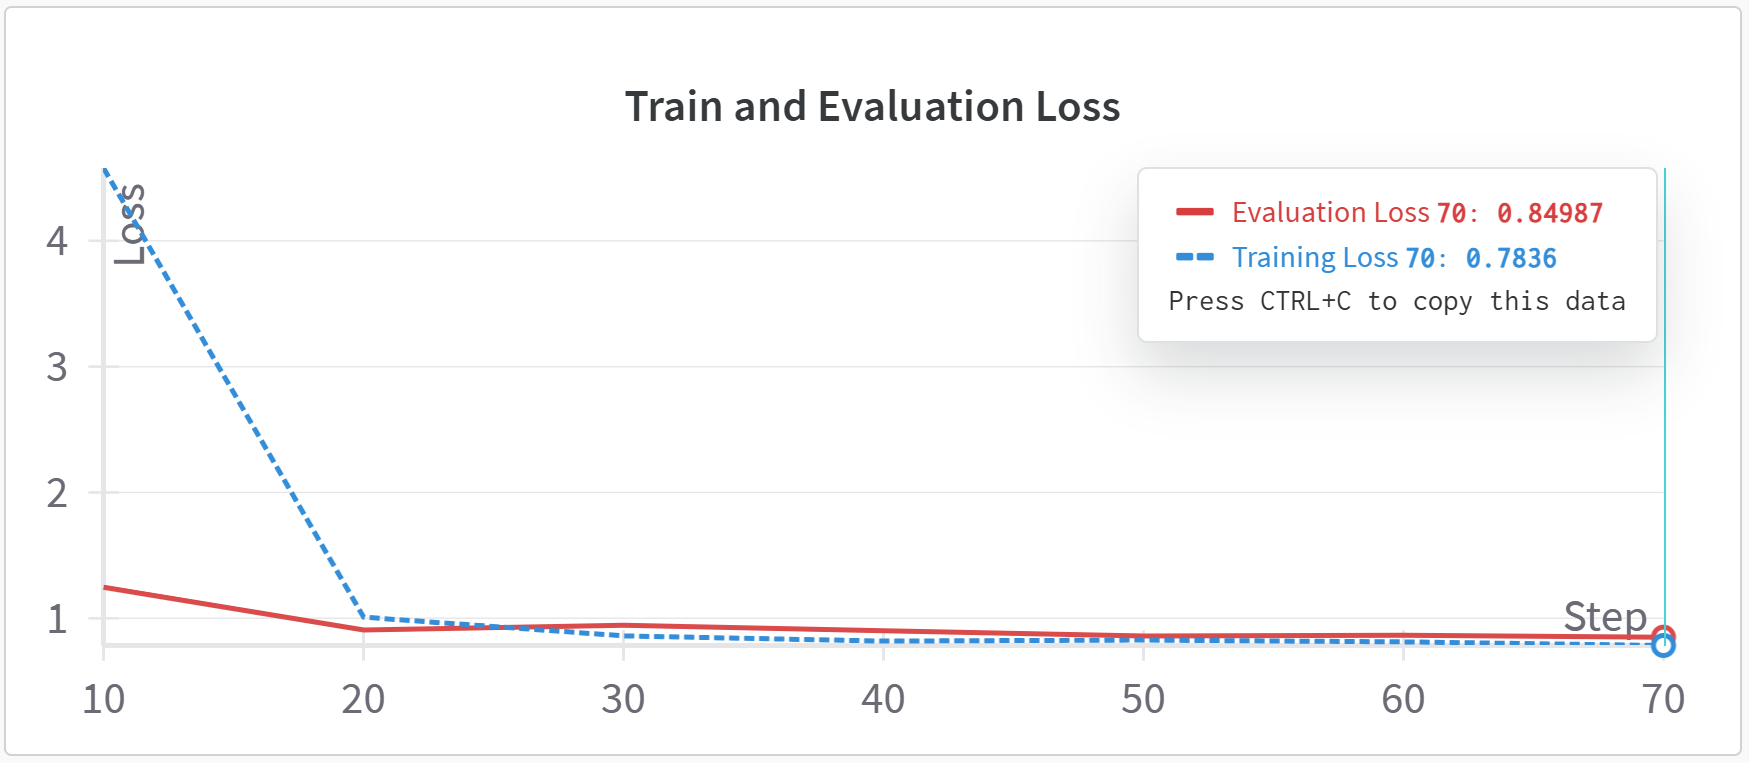

The second metric, and my favorite is viewing the live generations in real time. Since we added the custom W&B callback, we can go in a view what clues are being generated as the model changes. This let's us understand in a much more practical way whether the training is actually having an impact. In our case we want to understand whether the model is picking up the correct format of giving clues, and whether the clues seem to be getting better overtime.

<div style="text-align: center; margin: 20px 0;">
    <img src="https://github.com/rhyscook92/Kaggle-Gemma-Finetune/blob/main/images/W&B_training_table.PNG?raw=true" alt="Training and Evaluation Loss Plot" style="height: 400px; width: auto; max-width: 100%;">
</div>

**Figure 3**: This second screenshot of W&B shows how our clues get better with each step of training. We can see:

* Initially at epoch 0 Gemma's generation is very verbose (it's cut off in the screenshot but Gemma actually recommends three different clues, "forcefullness", "power source" and "what a superhero wields" before being cut off by the token limit. Note this clue is generated before any finetuning, because we set the trainer to evaluate at step zero. I find this useful as a baseline. 
* Then, by the second generation we see fine-tuning has taught the model the right format as it responds with a single crossword clue, albeit not a very good one.
* Finally, by about the third step which is 25% through an epoch, the fine-tuning has settled on a decent clue "physical power" provided in the expected context. 

<a id='save_model'></a>
## 4E. Saving the Trained Model ##
It's now time to save our model. Since we've used LoRA we need to first merge the model (that means combine our update matrices with the original model), and then we save it along with the tokenizer.

In [ ]:
# Merge LoRA weights with base model
merged_model = trainer.model.merge_and_unload()

# Save the full merged model
path = '/kaggle/working/crossword_gemma_new'
merged_model.save_pretrained(path)

# Save tokenizer separately
trainer.tokenizer.save_pretrained(path)

<a id='inference'></a>
# 5. Inference and Use-Cases #
<a id='load_model'></a>
## 5A. Loading the Model ##
Let's now load the fine-tuned model again for inference!

As required by the competition rules we've uploaded our trained model to Kaggle Models after the fine-tuning process. This means that anyone can feel free to use our model by [navigating to the model page](https://www.kaggle.com/models/rhysie/gemma-2-2b-crossword-finetune/PyTorch/default/1). 

In [ ]:
# Path to the model attached to the notebook
kaggle_model_path = '/kaggle/input/gemma-2-2b-crossword-finetune/pytorch/default/1/gemma_crossword_finetune'

# Load model with mixed precision (bfloat16) for efficiency
device = "cuda"
model = AutoModelForCausalLM.from_pretrained(
    kaggle_model_path, 
    device_map=device, 
    torch_dtype=torch.bfloat16
)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(kaggle_model_path)

<a id='testing_the_model'></a>
## 5B. Testing the Model's Robustness ##
Now that we have a trained model, let's rigorously test its performance. While our model generated reasonable clues for the holdout test set, we used that set to tune our hyperparameters. For a truly unbiased evaluation, we need one final test against professional-grade clues.

For this comparison, we'll use clues from the New York Times "mini" crossword - a daily puzzle designed to be completed in just a few minutes. We'll take sample words from these puzzles and compare the NYT clues against ones generated by our fine-tuned Gemma model.

First, let's create a helper function that streamlines the inference process by extracting just the crossword clue from Gemma's output, then, we use that helper function to test against the NTY clues.

In [ ]:
# Helper function for generating clues for a given word. 
def generate_clue(model, tokenizer, word, device, temperature=0, top_k=1):
    """
    Generate a crossword clue for a given word
    
    Args:
        model: The loaded model
        tokenizer: The loaded tokenizer
        word (str): Word to generate a clue for
        device (str): Device to use for inference
        temperature (float 0-1): model creativity
        top_k (int): Number of words to sample from
    """
    user_prompt = f"Generate a clever crossword clue for the word: '{word}':"
    prompt = f"<start_of_turn>user\n{user_prompt}<end_of_turn>\n<start_of_turn>model\n"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Only sample if temperature > 0
    do_sample = temperature > 0
    
    with torch.inference_mode():
        outputs = model.generate(
            **inputs,
            max_new_tokens=20,
            do_sample=do_sample,
            temperature=temperature,
            top_k=top_k)
        
    full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract just the clue part after "Clue: "
    if "Clue: " in full_text:
        clue = full_text.split("Clue: ")[-1].strip()
    else:
        # Fallback if format is different - get everything after "model\n"
        clue = full_text.split("model\n")[-1].strip()
        
    return clue

In [ ]:
# Now apply the helper function to the words that we have NYT clues for
new_york_times_words = {
    'words': ['CUBE', 'OMITS', 'BETS', 'GOAT', 'UNION', 'GONER'],
    'nyt_clues': [
        'Rubik\'s ___',
        'Leaves out',
        'All ___ are off!',
        'Petting zoo animal',
        'Labor Alliance',
        'One who\'s doomed to fail'
    ]
}

df = pd.DataFrame(new_york_times_words)
df['Gemma_clues'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x, device))

In [ ]:
# Now create a styled table for Kaggle display
from IPython.display import display, HTML

# Create a styled HTML table
styled_table = """
<style>
.crossword-table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
}
.crossword-table th {
    background-color: #2E4053;
    color: white;
    padding: 12px;
    text-align: left;
}
.crossword-table tr:nth-child(even) {
    background-color: #f2f2f2;
}
.crossword-table tr:nth-child(odd) {
    background-color: #ffffff;
}
.crossword-table td {
    padding: 10px;
    border-bottom: 1px solid #ddd;
}
.word-cell {
    font-weight: bold;
    color: #2874A6;
}
</style>

<table class="crossword-table">
    <tr>
        <th>Word</th>
        <th>NYT Clue</th>
        <th>Our Gemma Finetune's Clue</th>
    </tr>
"""

# Add each row to the table
for index, row in df.iterrows():
    styled_table += f"""
    <tr>
        <td class="word-cell">{row['words']}</td>
        <td>{row['nyt_clues']}</td>
        <td>{row['Gemma_clues']}</td>
    </tr>
    """

styled_table += "</table>"

# Display the styled table in Kaggle
display(HTML(styled_table))

**Table 2:** Comparison of our Gemma Finetune versus real NYT clues. 

**Where Gemma is doing well:** Interestingly Gemma arrives at the exact same clue for the word "Omits", simply choosing "Leaves out", which bodes wel for our model! The clue for BETS of "Wagers on a game or outcome" is also straight forward but quite good. Personally the author also quite like the choice for GOAT, where Gemma has landed on the clue "Best of the best" using the coloquilly meaning "greatest of all time" demonstrating that Gemma can build clues relevant to phrases currently popular in American English. Furthermore, Gemma has also mastered the format of just providing a single clue and no context, making this perfect for pipelines. 

**Where Gemma is doing poorly:** The clue for "UNION" contained the word united, which is too similar to the answer and thus a poor clue. Furthermore, the  clue for "GONER" generated is "Going to the next level" which doesn't make sense, although admitably coming up with a clue for Goner does feel difficult!

All in all the clues are decent, but some improvement would be nice. In the following section we'll try to overcome some limitations unearthed here. 

<a id='generating_american_clues'></a>
## 5.3 Generating English (American) Clues with Gemma ##
We've already mentioned how crosswords play a key role in English (American), and literary culture, and trained on American English words, but to really get further into the language let's have Gemma create some clues for some words unique to the American variant of English. 

What makes American English distinct from British English? Well, after American independence, the two nations began to develop more distinct cultural identities, and over time the languages diverged with certain styles becoming more popular in one region versus the other. American English has tended to adopt more straightforward spellings (color vs. colour) and embraced new terms that reflect its unique culture and development. A few typical examples of these distinctly American terms are:
* Fall (vs Autumn in British English)
* Subway (vs Underground or Tube in British English)
* Eggplant (vs aubergine in British English)
* Elevator (vs lift in Britsh English)

To demonstrate Gemma's ability to handle these American-specific terms, we'll generate crossword clues for a selection of distinctly American words.

Before that though, we saw in the section above that Gemma was doing an okay job generating crossword clues, but could be improved. To improve the clues generated, one approach is to use the parameters temperature and top_k, which basically control the creativity of the generations (higher values lead to more creative clues). We build three different sets of clues to review:

1. Direct clues (low creativity): temperature=0, top_k=1
2. Creative clues (medium creativity): temperature=0.7, top_k=5
3. Challenging clues (high creativity): temperature=1, top_k=15

In [ ]:
# Create initial DataFrame
american_english_words = {
    'words': ['CANDY', 'SUBWAY', 'FAUCET','FALL','EGGPLANT','SWEATER']
}
df = pd.DataFrame(american_english_words)

# Since we're using sampling, we need to set seeds to ensure each run of the notebook is the same
def set_seeds(seed=42): 
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()

# Generate three different sets of clues with varying creativity
df['Clue_Direct'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0, top_k=1))
df['Clue_Creative'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0.6, top_k=5))
df['Clue_Challenging'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0.9, top_k=20))

In [ ]:
# Create an enhanced styled table
from IPython.display import display, HTML

styled_table = """
<style>
.crossword-table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
    margin: 20px 0;
}
.crossword-table th {
    background-color: #2E4053;
    color: white;
    padding: 12px;
    text-align: left;
    border-bottom: 2px solid #1B2631;
}
.crossword-table tr:nth-child(even) {
    background-color: #f2f2f2;
}
.crossword-table tr:nth-child(odd) {
    background-color: #ffffff;
}
.crossword-table td {
    padding: 12px;
    border-bottom: 1px solid #ddd;
    line-height: 1.4;
}
.word-cell {
    font-weight: bold;
    color: #2874A6;
    width: 15%;
}
.clue-cell {
    width: 28%;
}
.clue-header {
    font-size: 0.9em;
}
</style>
<table class="crossword-table">
    <tr>
        <th>Word</th>
        <th>Direct Clue<br><span class="clue-header">(Low Temp)</span></th>
        <th>Creative Clue<br><span class="clue-header">(Med Temp)</span></th>
        <th>Abstract Clue<br><span class="clue-header">(High Temp)</span></th>
    </tr>
"""

# Add each row to the table
for index, row in df.iterrows():
    styled_table += f"""
    <tr>
        <td class="word-cell">{row['words']}</td>
        <td class="clue-cell">{row['Clue_Direct']}</td>
        <td class="clue-cell">{row['Clue_Creative']}</td>
        <td class="clue-cell">{row['Clue_Challenging']}</td>
    </tr>
    """

styled_table += "</table>"

# Display the styled table
display(HTML(styled_table))

**Table 3:** Gemma's Clues for American English.


Here we can see a few suggestions from Gemma for various American English words. As temperature increases we start to see a small drop in the formatting, with the model adding things like the number of letters in the answer in but we also see a little more creativity, for example, the mid-temperature clue for "FALL" is "Drop to the ground, perhaps with a leaf" which is quite clever, since it simultanously talks about somebody falling which is one meaning of fall, but also hints at leafs which are part of the fall season. As someone who is also partial to stuffed eggplant, that clue "Purple, round, and often stuff" is quite appreciated too!

The most important thing for us though, is that between the three different levels of creativity we have at least one good crossword clue for each word. 

<a id='interact_with_gemma'></a>
# 5D. A Chance to Interact with Gemma #
Woah! We've been through a lot to get this version of Gemma just right and finally we generated some clues for some distincively American English words. 

That's great but we didn't just do this as an academic exercise did we? (Okay we kinda did). But that said, it's always good to see how something works in practice, so here's an app the authors pulled together where you can see whether you can [solve a crossword puzzle](https://finetunecrossword.online/) where all the clues are built by this Gemma 2 finetune (app might take a few seconds to load!). I've included a few from the above table, and there's an appendix below that includes the generation of the remaining clues so you won't have seen all the clues already. If you get stuck, just hit the help button and either reveal individual squares, or if you're just keen for the answers reveal the full puzzle.

Good luck!

<center>
    <img src="https://github.com/rhyscook92/Kaggle-Gemma-Finetune/blob/main/images/crosswordfinetune_screenshot.PNG?raw=true" width="800px">
</center>

**Figure 4:** A screenshot of the full crossword, just incase the application isn't working! 

<a id='conclusion'></a>
# 6. Conclusion #
Hopefully you made it through the crossword! Let's end with a quick summary of what we've seen.

* We set out to learn how to fine-tune Gemma, but also study English (American) through a particular cultural lense, namely that of the simple crossword puzzles which has been around for over 100 years. 
* Next we needed a dataset and avoid any ethical grey areas we developed a synthetic set of crossword clues by using the current frontier models.
* We then finetuned Gemma 2 which included:
    * Choosing the right model for our use-case (Gemma 2, 2b-it)
    * Formatting our dataset for fine-tuning
    * Finetuning parameters such as learning rate, and LoRA parameters.
    * We also took a quick tangent to see Weights and Biases in action.
* We then uploaded our model to kaggle, showed how to load the model for inference, and compared our clues to those made by professionals to test robustness.
* Finally, we generated some clues for some distinctively English (American) words using a variety of interence parameters, and let the reader work through them in a live application to see Gemma 2 in the wild. 

Hopefully you've found this notebook both informative and enjoyable, and I certainly found building it to be both those things, and thanks Gemma Team and Kaggle for the competition!

Links:
* [Dataset published on Kaggle](https://www.kaggle.com/datasets/rhysie/ai-generated-crossword-clues)
* [Code to build the dataset on Github](https://github.com/rhyscook92/Kaggle-Gemma-Finetune)
* [Finetuned Model published on Kaggle](https://www.kaggle.com/models/rhysie/gemma-2-2b-crossword-finetune/PyTorch/default/1)

<a id='appendix'></a>
# 7. Appendix - Additional Words #
This section generates the candidate clues to the remaining words used in the crossword linked above.

In [ ]:

# Create initial DataFrame
data = {
    'words': ['BANDAID', 'SNEAKERS', 'TRASH','DIAPER','SIDEWALK','ELEVATOR']
}
df = pd.DataFrame(data)
set_seeds()

# Generate three different sets of clues with varying parameters
df['Clue_Direct'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0, top_k=1))
df['Clue_Creative'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0.6, top_k=5))
df['Clue_Challenging'] = df['words'].apply(lambda x: generate_clue(model, tokenizer, x.lower(), device, temperature=0.9, top_k=20))


In [ ]:
# Create an enhanced styled table
from IPython.display import display, HTML

styled_table = """
<style>
.crossword-table {
    border-collapse: collapse;
    width: 100%;
    font-family: Arial, sans-serif;
    margin: 20px 0;
}
.crossword-table th {
    background-color: #2E4053;
    color: white;
    padding: 12px;
    text-align: left;
    border-bottom: 2px solid #1B2631;
}
.crossword-table tr:nth-child(even) {
    background-color: #f2f2f2;
}
.crossword-table tr:nth-child(odd) {
    background-color: #ffffff;
}
.crossword-table td {
    padding: 12px;
    border-bottom: 1px solid #ddd;
    line-height: 1.4;
}
.word-cell {
    font-weight: bold;
    color: #2874A6;
    width: 15%;
}
.clue-cell {
    width: 28%;
}
.clue-header {
    font-size: 0.9em;
}
</style>
<table class="crossword-table">
    <tr>
        <th>Word</th>
        <th>Direct Clue<br><span class="clue-header">(Low Temp)</span></th>
        <th>Creative Clue<br><span class="clue-header">(Med Temp)</span></th>
        <th>Abstract Clue<br><span class="clue-header">(High Temp)</span></th>
    </tr>
"""

# Add each row to the table
for index, row in df.iterrows():
    styled_table += f"""
    <tr>
        <td class="word-cell">{row['words']}</td>
        <td class="clue-cell">{row['Clue_Direct']}</td>
        <td class="clue-cell">{row['Clue_Creative']}</td>
        <td class="clue-cell">{row['Clue_Challenging']}</td>
    </tr>
    """

styled_table += "</table>"

# Display the styled table
display(HTML(styled_table))

**Table 4** Some more distincly American English words, and Gemma's clues. The clue for "BANDAID" which is "Quick Fix for a scrape" is very apt, and "Up and down, without stairs" for "ELEVATOR" is another stand out. 